# Transposases

In [1]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons
from PhiSpyAnalysis import read_transposons_per_phage

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA



In [2]:
use_small_data=False

In [3]:
checkv=read_checkv()
checkv

,Prophage,contig_length,gene_count,checkv_quality
0,BX897700.1_PP1,15580,16,Not-determined
1,BX897700.1_PP2,52808,46,Low-quality
2,BX897700.1_PP3,28623,36,Not-determined
3,BX897699.1_PP1,58738,91,Medium-quality
4,BX897699.1_PP2,55416,59,Medium-quality
...,...,...,...,...
3210638,CADILH010000016.1_PP3,23300,26,Not-determined
3210639,CADILL010000001.1_PP1,24881,27,Not-determined
3210640,CADILL010000007.1_PP2,16691,17,Not-determined
3210641,CADILN010000005.1_PP1,18647,22,Low-quality


In [4]:
tns = read_transposons_per_phage()
tns

,phage,transpoase
0,AAEWSU010000037.1_PP9,1
1,AAIOSE010000040.1_PP10,1
2,NWSB01000019.1_PP4,1
3,VDFC01000058.1_PP22,1
4,AAAAIU010000025.1_PP3,1
...,...,...
540329,AAOTBO010000062.1_PP5,1
540330,CP013688.1_PP3,2
540331,AAPBQK010000001.1_PP2,1
540332,AAJACB010000041.1_PP3,1


In [19]:
tns[tns['transpoase']==0]

,phage,transpoase


In [5]:
tns = tns.drop(tns[tns['transpoase'] > 50].index)

In [6]:
tncv = pd.merge(checkv, tns, left_on='Prophage', right_on='phage', how='inner')
tncv

,Prophage,contig_length,gene_count,checkv_quality,phage,transpoase
0,BX936398.1_PP2,141149,188,High-quality,BX936398.1_PP2,5
1,CP001046.1_PP5,22994,24,Not-determined,CP001046.1_PP5,2
2,CP001046.1_PP6,28865,32,Not-determined,CP001046.1_PP6,2
3,CP001048.1_PP2,18054,21,Not-determined,CP001048.1_PP2,1
4,CP001048.1_PP4,56117,77,Complete,CP001048.1_PP4,3
...,...,...,...,...,...,...
532032,CADDXA010000005.1_PP1,48604,49,Medium-quality,CADDXA010000005.1_PP1,2
532033,CADDXA010000030.1_PP3,17939,28,Not-determined,CADDXA010000030.1_PP3,1
532034,LR793264.1_PP1,37489,50,Medium-quality,LR793264.1_PP1,2
532035,LR793264.1_PP4,21293,23,Medium-quality,LR793264.1_PP4,4


<AxesSubplot:xlabel='checkv_quality', ylabel='transpoase'>

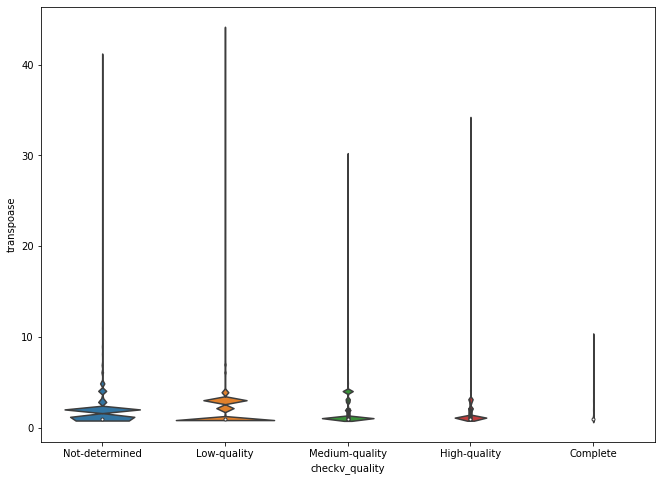

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sns.violinplot(x='checkv_quality', y='transpoase', data=tncv, scale='count', order=['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality', 'Complete'], ax=ax)

<AxesSubplot:xlabel='checkv_quality', ylabel='transpoase'>

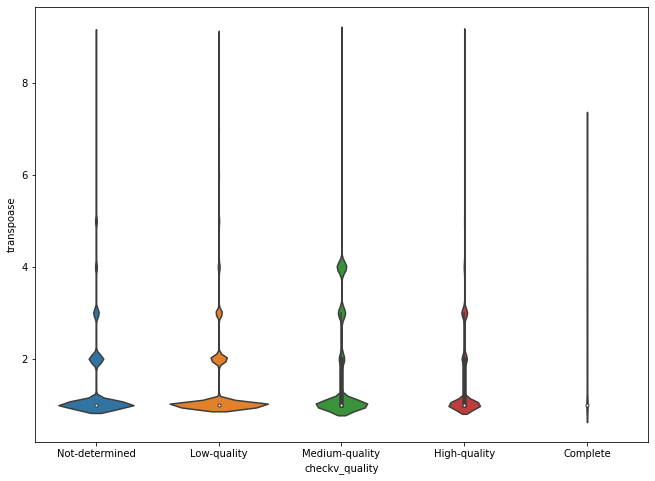

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sns.violinplot(x='checkv_quality', y='transpoase', data=tncv[tncv['transpoase'] < 10], scale='count', order=['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality', 'Complete'], ax=ax)

<AxesSubplot:xlabel='contig_length', ylabel='transpoase'>

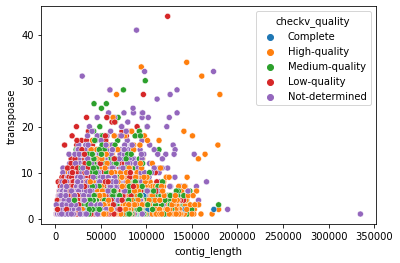

In [9]:
sns.scatterplot(x='contig_length', y='transpoase', data=tncv, hue='checkv_quality', hue_order=['Complete', 'High-quality', 'Medium-quality', 'Low-quality', 'Not-determined'])

<AxesSubplot:xlabel='contig_length', ylabel='transpoase'>

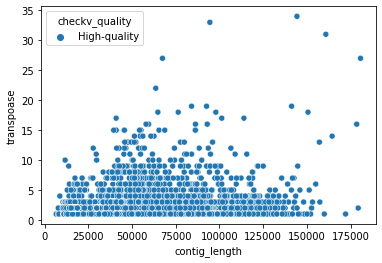

In [10]:
#sns.scatterplot(x='contig_length', y='transpoase', data=tncv[tncv['checkv_quality'] == 'Complete'], hue='checkv_quality')
sns.scatterplot(x='contig_length', y='transpoase', data=tncv[tncv['checkv_quality'] == 'High-quality'], hue='checkv_quality')

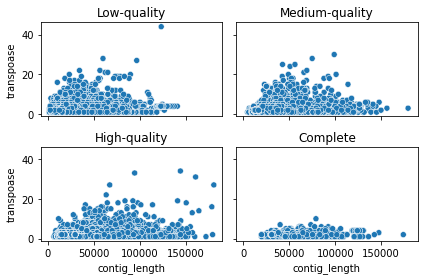

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
d = [['Low-quality', 'Medium-quality'], ['High-quality', 'Complete']]
x = 'contig_length'
for i in 0, 1:
    for j in 0, 1:
        sns.scatterplot(x=x, y='transpoase', data=tncv[tncv['checkv_quality'] == d[i][j]], hue='checkv_quality', ax=ax[i][j], legend=False)
        ax[i][j].set_title(d[i][j])
plt.tight_layout()
plt.show()
        

In [12]:
tncv[(tncv['checkv_quality'] == 'Low-quality') & (tncv['transpoase'] > 75)]

,Prophage,contig_length,gene_count,checkv_quality,phage,transpoase


In [13]:
tncv.drop(38935)

,Prophage,contig_length,gene_count,checkv_quality,phage,transpoase
0,BX936398.1_PP2,141149,188,High-quality,BX936398.1_PP2,5
1,CP001046.1_PP5,22994,24,Not-determined,CP001046.1_PP5,2
2,CP001046.1_PP6,28865,32,Not-determined,CP001046.1_PP6,2
3,CP001048.1_PP2,18054,21,Not-determined,CP001048.1_PP2,1
4,CP001048.1_PP4,56117,77,Complete,CP001048.1_PP4,3
...,...,...,...,...,...,...
532032,CADDXA010000005.1_PP1,48604,49,Medium-quality,CADDXA010000005.1_PP1,2
532033,CADDXA010000030.1_PP3,17939,28,Not-determined,CADDXA010000030.1_PP3,1
532034,LR793264.1_PP1,37489,50,Medium-quality,LR793264.1_PP1,2
532035,LR793264.1_PP4,21293,23,Medium-quality,LR793264.1_PP4,4


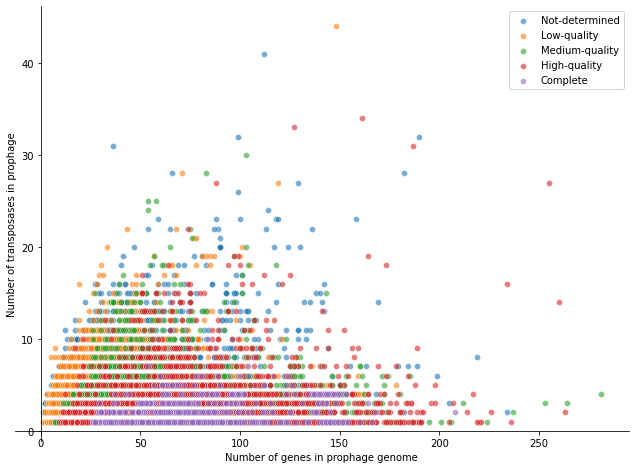

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
pal = sns.color_palette("flare", as_cmap=True)
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality', 'Complete']:
    sns.scatterplot(x='gene_count', y='transpoase', data=tncv[tncv['checkv_quality']==c], label=c, alpha=0.6, ax=ax, palette=pal)
l = ax.set_xlabel('Number of genes in prophage genome')
l = ax.set_ylabel('Number of transposases in prophage')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
#l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig(f"images/transposons_per_phage_gene.svg")

<AxesSubplot:xlabel='gene_count', ylabel='transpoase'>

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


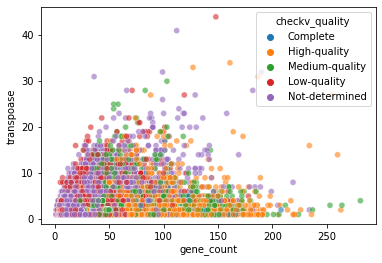

In [15]:
sns.scatterplot(x='gene_count', y='transpoase', data=tncv, hue='checkv_quality', hue_order=['Complete', 'High-quality', 'Medium-quality', 'Low-quality', 'Not-determined'], alpha=0.6)

In [16]:
tncv.dtypes

Prophage          object
contig_length      int64
gene_count         int64
checkv_quality    object
phage             object
transpoase         int64
dtype: object

In [17]:
ho=['Medium-quality', 'High-quality']
sns.scatterplot(x='completeness', y='transpoase', data=tncv, hue='checkv_quality')
#, hue_order=['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality'])

ValueError: Could not interpret value `completeness` for parameter `x`

In [ ]:
sns.scatterplot(x='host_genes', y='transpoase', data=tncv, hue='checkv_quality')